# **Exercise 1: Analyzing Energy Performance of Buildings**

## Overview

In this exercise, we use the publicly available [Energy Performance of Buildings Data](https://epc.opendatacommunities.org/domestic/search) to assess how different factors, such as built form, heating efficiency, and total floor area, affect energy building consumption. By the end of this exercise, you should be able to:
- Process, visualize, and interpret building energy performance data.
- Use descriptive/predictive analytics to identify factors that drive energy consumption.

## Set up

Load the required Python libraries and the data set. The data set contains information from 5000 buildings located in the London borough of Islington and is stored ```...\data raw\epc-certificates-Islington```; file ```certificates.csv``` contains the data and ```columns.csv``` explains the colunm headers. To load the data, update the ```path``` variable to the local folder location. 

For simplicity, columns with ```NaN``` values are dropped. An auxiliary function that estimates predictive accuracy, namely, mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE), is provided.

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def accuracy_metrics(actual, predictions):
    ''' Estimate predictive accuracy metrics '''
    actual_copy = actual.copy().reshape(-1,1)
    predictions_copy = predictions.copy().reshape(-1,1)
    
    error = actual_copy - predictions_copy    
    assert(error.shape[0] == len(actual_copy))
    if error.ndim > 1:        
        assert(error.shape[1] == 1)

    mse = np.square(error).mean()
    rmse = np.sqrt( mse )
    mae = np.abs(error).mean()
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    return rmse, mae

# default settings for plots
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (10,3)

# load data
# !!!! Update the path variable
path = 'C:\\Users\\ucbva19\\Git projects\\energy_analytics_built_env\\data raw\\epc-certificates-Islington'
df = pd.read_csv(f"{path}\\certificates.csv")  # change path

print(df.head())
print(df.isna().sum())

# drop columns with NaNs
df = df.dropna(axis=1)

assert(df.isna().sum().sum() == 0)

                                             LMK_KEY          ADDRESS1  \
0  05a4e13c8f8892b40f457e58195271839c253e738b2a4a...            Flat A   
1  07c0c456133427557a94e545821381d14767982acbf6cb...           Flat 17   
2  09ff1f899a2a4bfa4b183664b5d95962f6f636beba7616...           Flat 13   
3  104aed0a570454905c714411fff45406314dbb0cdcbf92...  144a Hanley Road   
4  117e6ac108ca5cb9de1ac1c4f5c82f526f8a6f7be28bf9...           Flat 16   

                  ADDRESS2            ADDRESS3 POSTCODE  \
0           32 Hanley Road                 NaN   N4 3DR   
1  Park Gate House 250-252  Seven Sisters Road   N4 2HU   
2  Park Gate House 250-252  Seven Sisters Road   N4 2HU   
3                      NaN                 NaN   N4 3DW   
4  Park Gate House 250-252  Seven Sisters Road   N4 2HU   

   BUILDING_REFERENCE_NUMBER CURRENT_ENERGY_RATING POTENTIAL_ENERGY_RATING  \
0                10008499045                     D                       C   
1                10003804896                

### Preliminary analysis

As an example of preliminary analysis, we generate a few informative plots and descriptive statistics.

count    5000.000000
mean      177.686200
std       101.079758
min       -14.000000
25%       134.000000
50%       167.000000
75%       206.000000
max      5365.000000
Name: ENERGY_CONSUMPTION_CURRENT, dtype: float64
count    5000.00000
mean      593.40980
std       412.83544
min        37.00000
25%       354.00000
50%       493.00000
75%       699.00000
max      4787.00000
Name: HEATING_COST_CURRENT, dtype: float64
count     5000
unique       6
top          C
freq      3120
Name: CURRENT_ENERGY_RATING, dtype: object


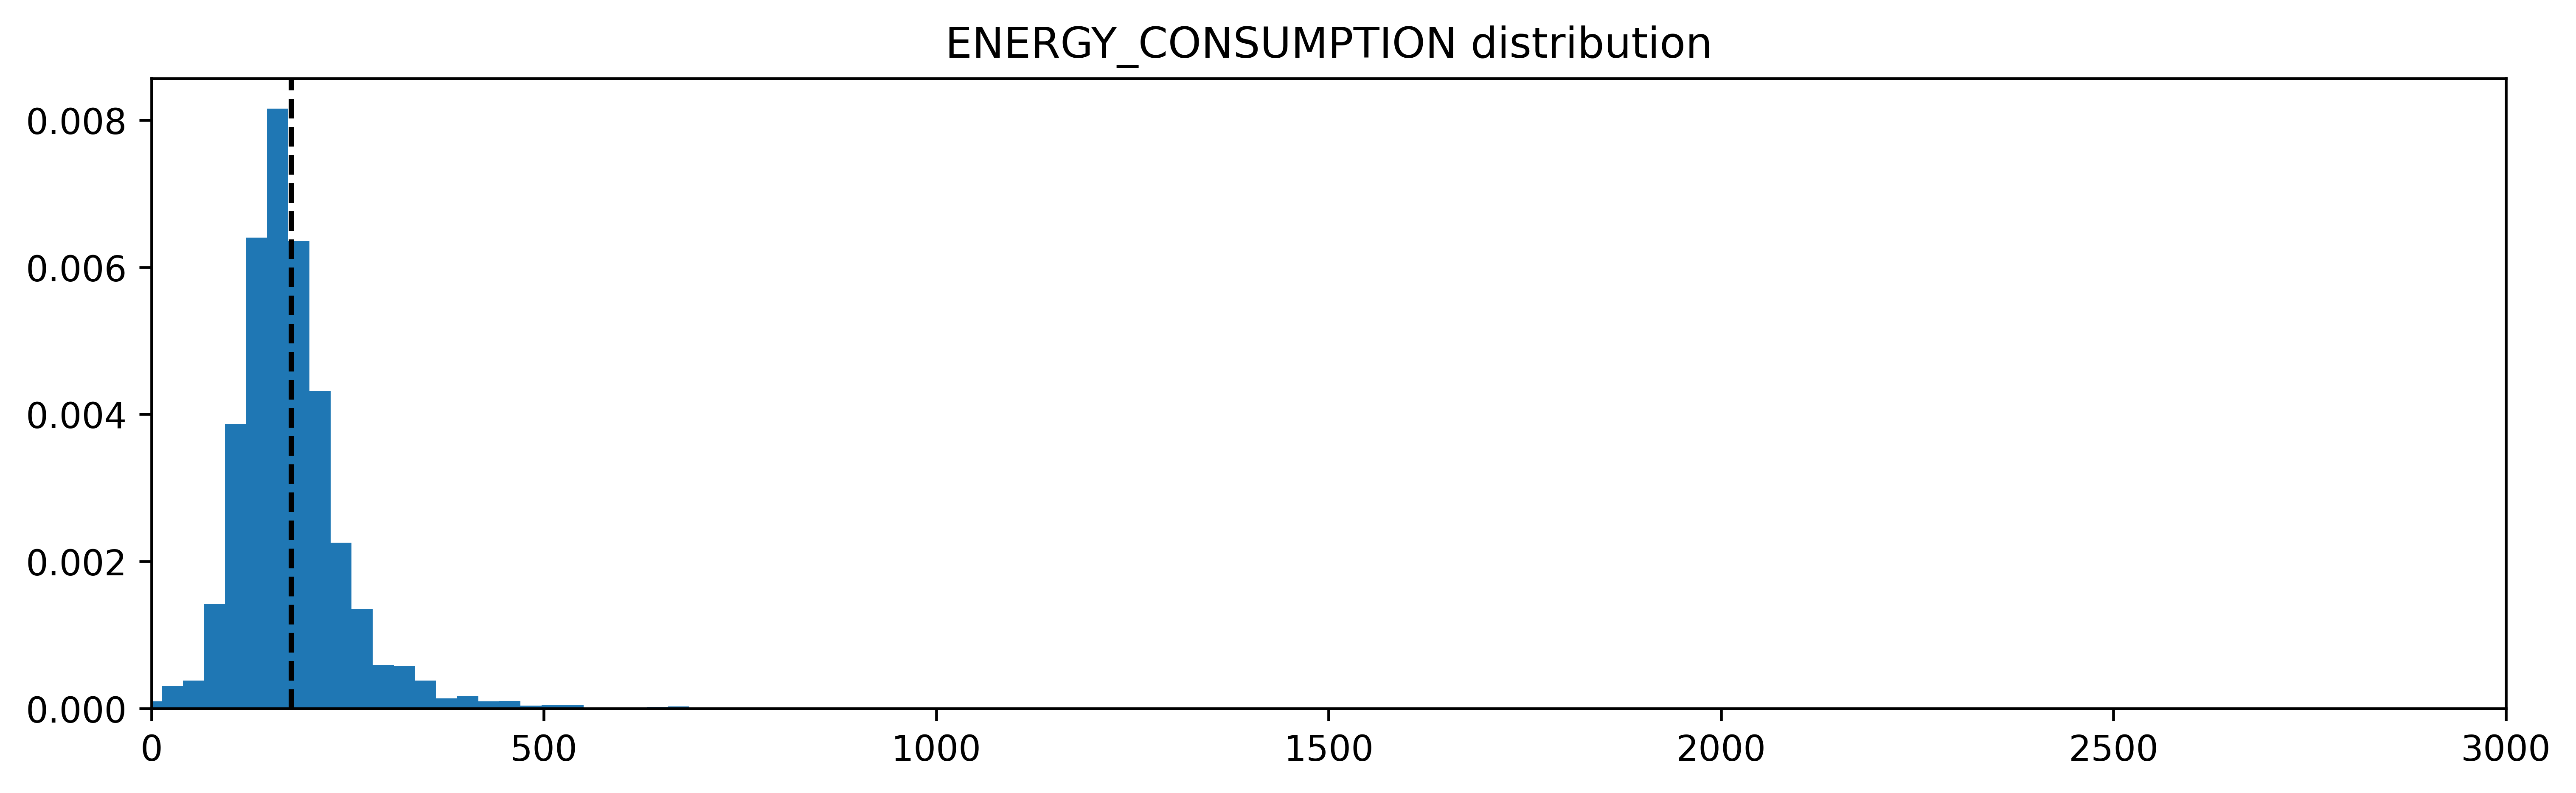

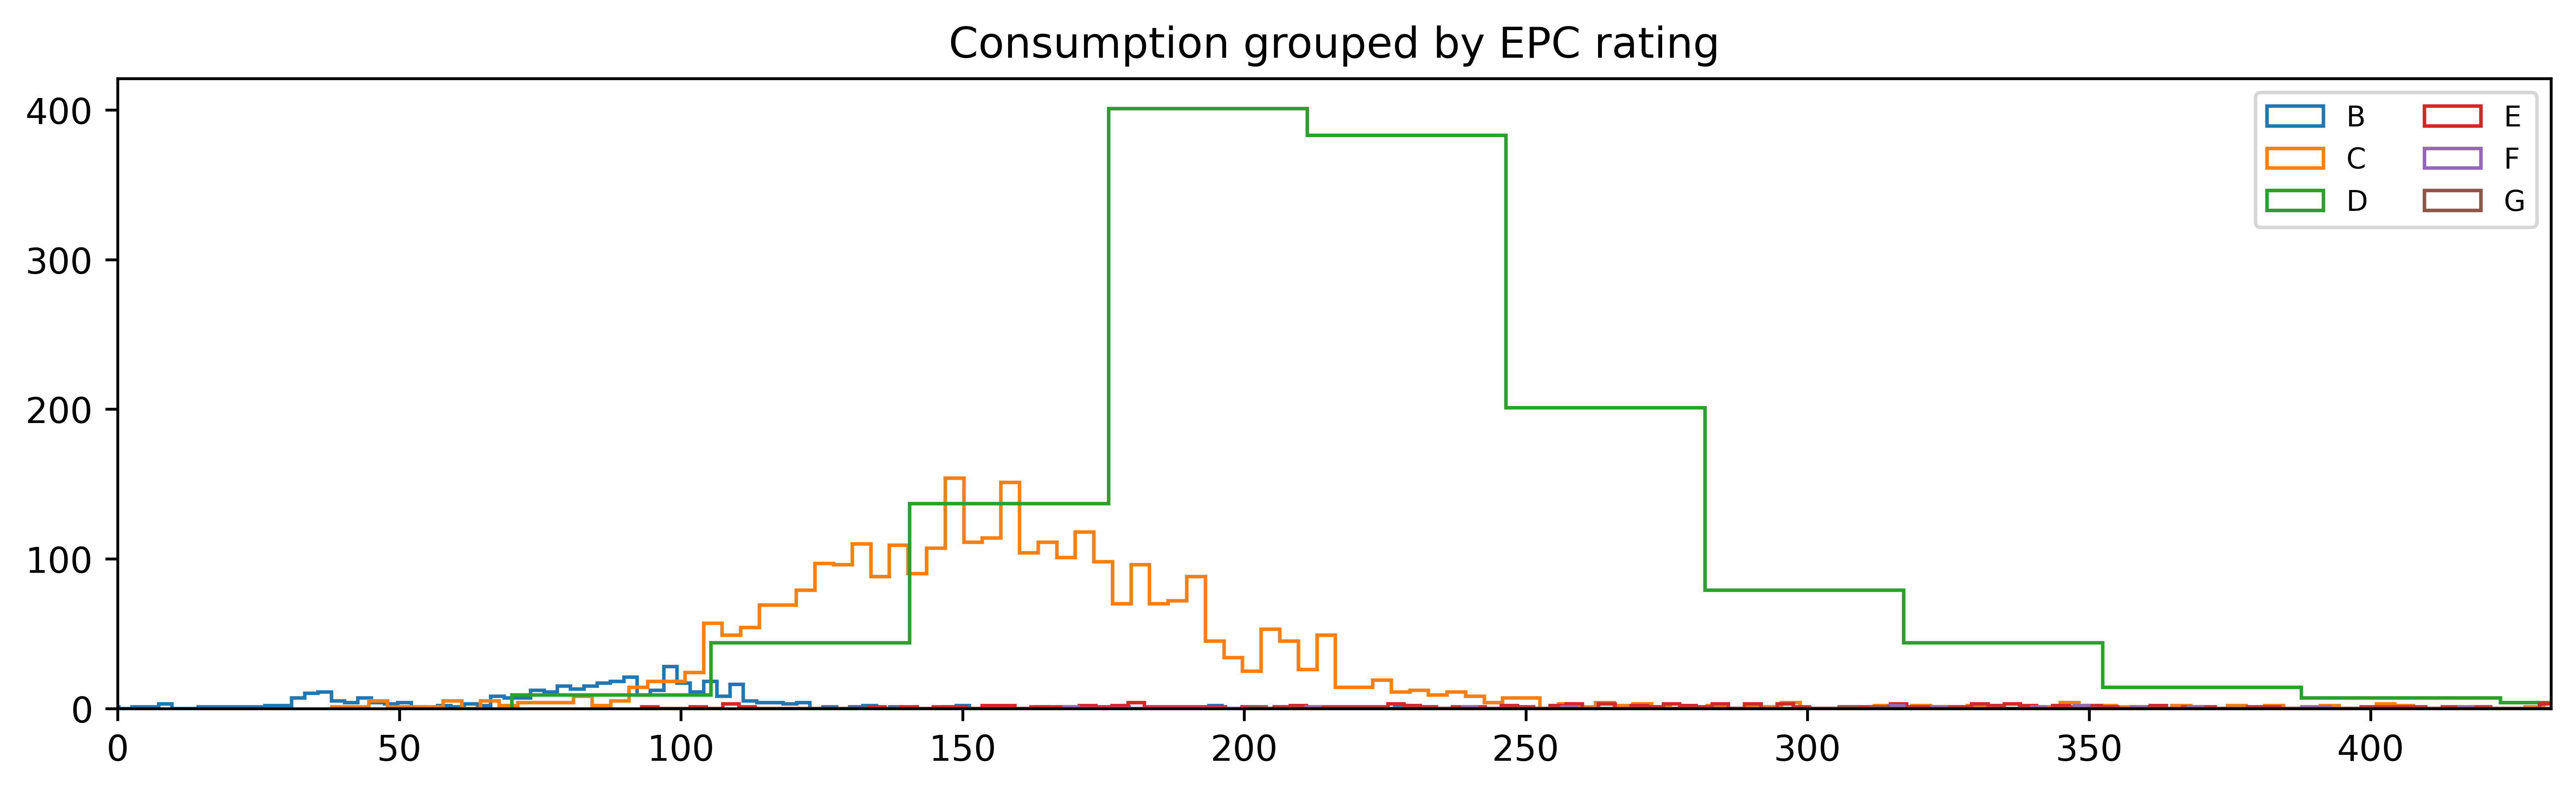

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_904\2835056043.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels = cats, showfliers=False)


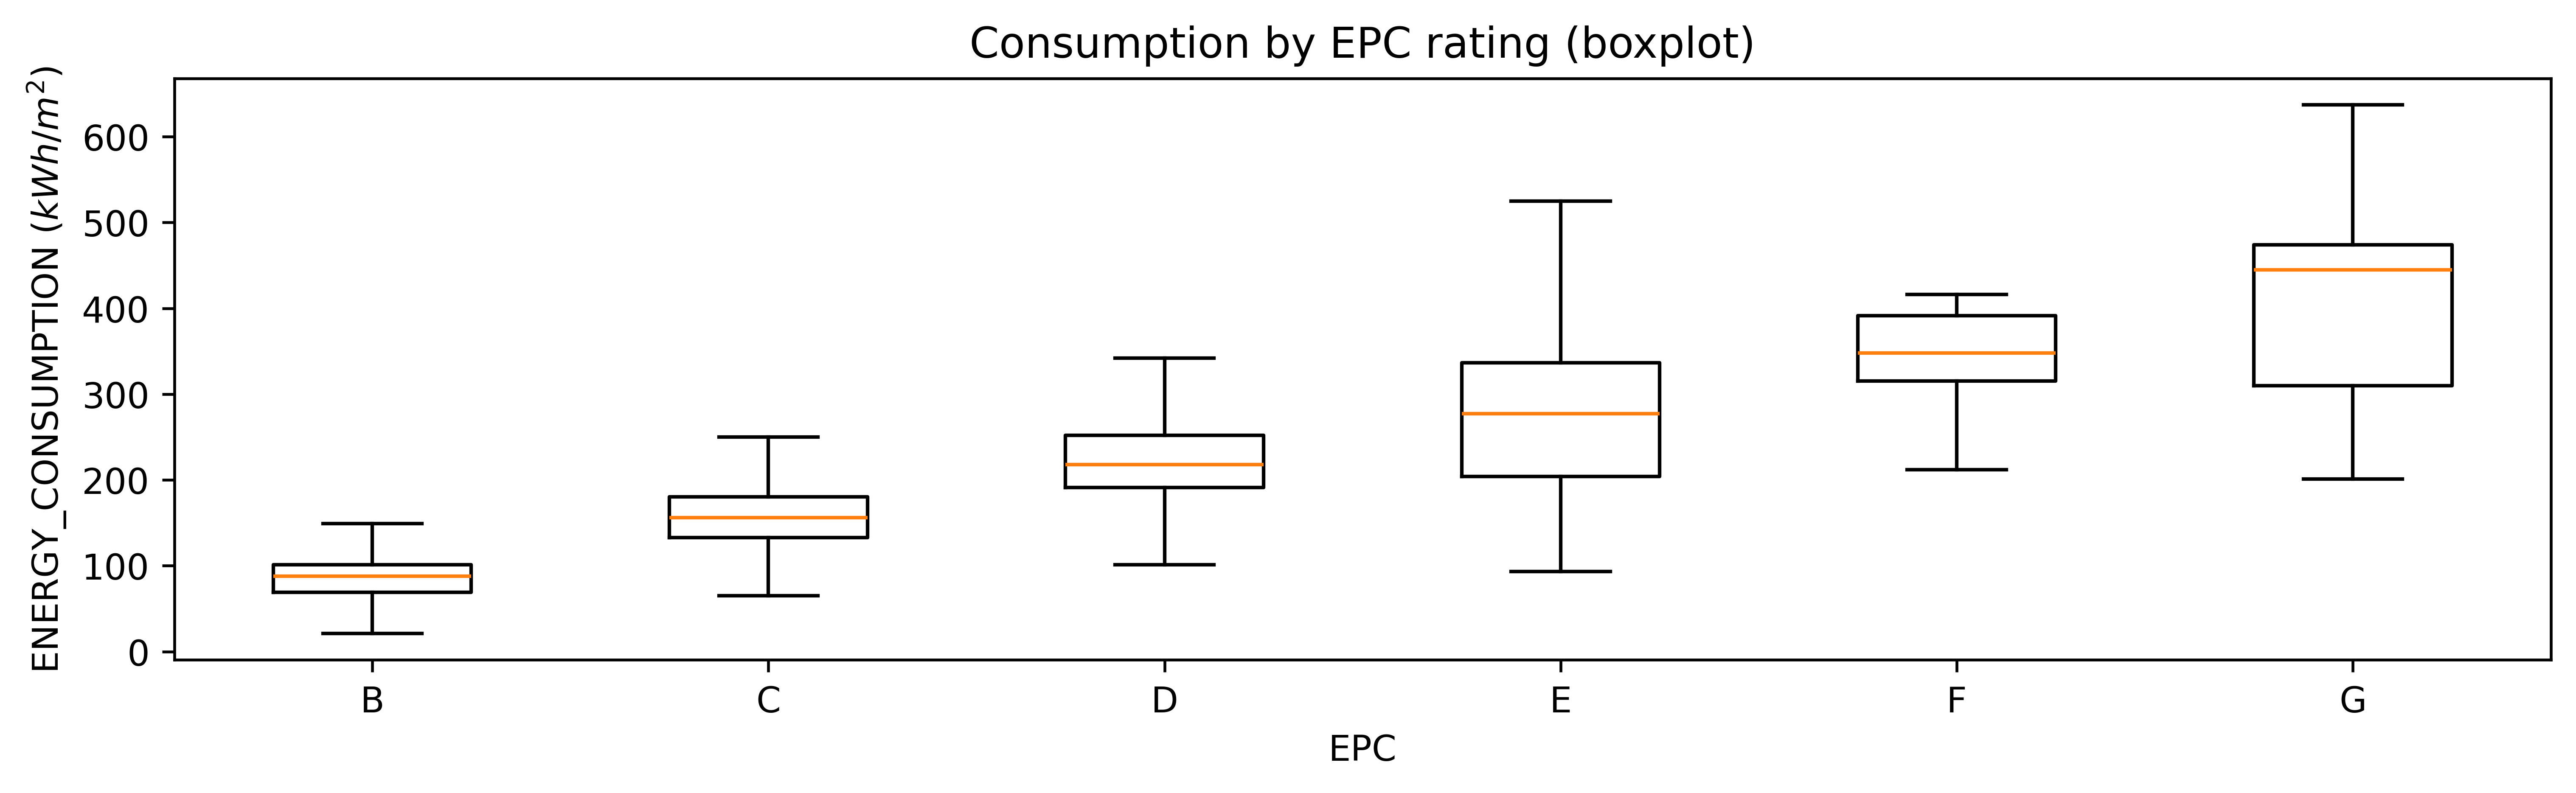

In [2]:
# Descriptive statistics
print(df['ENERGY_CONSUMPTION_CURRENT'].describe())
print(df['HEATING_COST_CURRENT'].describe())
print(df['CURRENT_ENERGY_RATING'].describe())

# Plot distribution
plt.figure()
plt.hist(df["ENERGY_CONSUMPTION_CURRENT"], bins=200, density=True)
plt.axvline(df["ENERGY_CONSUMPTION_CURRENT"].mean(), linestyle="--", color = 'black')
plt.xlim(0, 3000)
plt.title("ENERGY_CONSUMPTION distribution")
plt.show()


# EPC rating counts
plt.figure()
for k, g in df.groupby("CURRENT_ENERGY_RATING"):
    plt.hist(g["ENERGY_CONSUMPTION_CURRENT"], bins=150, histtype="step", label=str(k))
plt.xlim(0, df["ENERGY_CONSUMPTION_CURRENT"].quantile(0.99))
plt.title("Consumption grouped by EPC rating")
plt.legend(ncol=2, fontsize=8)
plt.show()

# Boxplot by EPC
plt.figure()
cats = sorted(df["CURRENT_ENERGY_RATING"].dropna().unique())
data = [df.loc[df["CURRENT_ENERGY_RATING"] == c, "ENERGY_CONSUMPTION_CURRENT"].values for c in cats]
plt.boxplot(data, labels = cats, showfliers=False)
plt.title("Consumption by EPC rating (boxplot)")
plt.xlabel("EPC")
plt.ylabel("ENERGY_CONSUMPTION $(kWh/m^2)$")
plt.show()

### Which factor drives energy consumption?

Your task is to assess which factor affects ```ENERGY_CONSUMPTION_CURRENT``` the most. You may use any descriptive or predictive method that consider appropriate. A few useful tips:
- Focus on the following list of features: ```['CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA', 'WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 
                    'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF', 'PROPERTY_TYPE', 'BUILT_FORM']```.
- Note that ```'CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA', 'WALLS_ENERGY_EFF'``` are numerical features, whereas the rest need to be encoded either as categorical or as ordinal features.
- There multiple ways to tackle this problem. For instance, you can apply linear regression analysis and conduct statistical tests. Alternatively, you can train predictive machine learning (ML) models and calculate relevant feature importance metrics, e.g., Shapley values.

In [3]:
target_variable = 'ENERGY_CONSUMPTION_CURRENT'
feature_list = ['CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA',
            'WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF', 'PROPERTY_TYPE', 'BUILT_FORM']

Y = df[target_variable]
X = df[feature_list]

for c in ['WALLS_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'LIGHTING_ENERGY_EFF', 'HOT_WATER_ENERGY_EFF', 'PROPERTY_TYPE', 'BUILT_FORM']:
    print(f'Feature: {c}')
    print(f'Categories: {X[c].unique()}')

Feature: WALLS_ENERGY_EFF
Categories: ['Poor' 'Good' 'Average' 'Very Poor' 'Very Good']
Feature: MAINHEAT_ENERGY_EFF
Categories: ['Good' 'Average' 'Very Poor' 'Poor' 'Very Good']
Feature: LIGHTING_ENERGY_EFF
Categories: ['Good' 'Average' 'Poor' 'Very Poor' 'Very Good']
Feature: HOT_WATER_ENERGY_EFF
Categories: ['Good' 'Average' 'Very Poor' 'Poor' 'Very Good']
Feature: PROPERTY_TYPE
Categories: ['Flat' 'Maisonette' 'House' 'Bungalow']
Feature: BUILT_FORM
Categories: ['Not Recorded' 'Mid-Terrace' 'Semi-Detached' 'End-Terrace'
 'Enclosed End-Terrace' 'Enclosed Mid-Terrace' 'Detached']


In [4]:
### Enter your code here